In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_VICTIM = 40    # Train shirt model
EPOCHS_ATTACKER = 40  # Train "adversarial ones" model
attack_dim = 64
victim_dim = 16

# --- 1. VAE DEFINITION ---
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        # Encoder
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_logvar = nn.Linear(hidden_dim, z_dim)
        # Decoder
        self.dec1 = nn.Linear(z_dim, hidden_dim)
        self.dec_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.enc1(x))
        return self.enc_mu(h), self.enc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec1(z))
        return torch.sigmoid(self.dec_out(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# --- 2. LOG-LIKELIHOOD ESTIMATION (IMPORTANCE SAMPLING) ---
def compute_log_likelihood_is(model, x, k=10):
    """
    Computes log P(x) using Importance Sampling:
    log P(x) ≈ log(1/K * sum( P(x|z)P(z)/Q(z|x) ))
    x: [batch_size, input_dim]
    """
    x = x.view(-1, 784)
    batch_size = x.size(0)

    # 1. Get parameters of Q(z|x)
    mu, logvar = model.encode(x)  # [B, Z]
    std = torch.exp(0.5 * logvar)

    # 2. Sample K times z ~ Q(z|x)
    eps = torch.randn(k, batch_size, model.z_dim).to(DEVICE)
    z = mu.unsqueeze(0) + eps * std.unsqueeze(0)  # [K, B, Z]

    # 3. Compute log P(x|z) (reconstruction term)
    recon_x = model.decode(z.view(-1, model.z_dim)).view(k, batch_size, -1)

    # Binary cross-entropy manually for log-probs
    recon_x = torch.clamp(recon_x, 1e-7, 1 - 1e-7)
    x_expanded = x.unsqueeze(0).expand(k, batch_size, 784)
    log_p_x_z = (x_expanded * torch.log(recon_x) +
                 (1 - x_expanded) * torch.log(1 - recon_x)).sum(-1)  # [K, B]

    # 4. log P(z) (standard Gaussian prior)
    log_p_z = -0.5 * (torch.sum(z ** 2, dim=-1) +
                      model.z_dim * torch.log(torch.tensor(2 * np.pi)))

    # 5. log Q(z|x)
    z_diff = z - mu.unsqueeze(0)
    log_q_z_x = -0.5 * (torch.sum((z_diff / std.unsqueeze(0)) ** 2, dim=-1) +
                        torch.sum(logvar.unsqueeze(0), dim=-1) +
                        model.z_dim * torch.log(torch.tensor(2 * np.pi)))

    # 6. Log-weights
    log_w = log_p_x_z + log_p_z - log_q_z_x

    # 7. LogSumExp - log(K)
    log_likelihood = torch.logsumexp(log_w, dim=0) - torch.log(torch.tensor(float(k)))

    return log_likelihood  # [B]


# --- 3. TRAINING FUNCTIONS ---
def standard_vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train_victim(model, dataloader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=LR)
    model.train()
    print(f"--> Training Victim (Shirts FMNIST) - Latent Dim: {model.z_dim}")
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(DEVICE)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = standard_vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(dataloader.dataset):.2f}")
    return model


def train_attacker(attacker, victim, dataloader, epochs, attack_lambda=5.0):
    """
    attacker: VAE of 'Ones' (High dimensional latent)
    victim: Shirt-VAE (Frozen)
    attack_lambda: weight of maximizing log P_victim(x_attacker)
    """
    optimizer = optim.Adam(attacker.parameters(), lr=LR)
    attacker.train()
    victim.eval()  # Freeze victim

    print(f"\n--> Training Attacker (Adversarial Ones) - Latent Dim: {attacker.z_dim}")
    print(f"--> Objective: Look like a '1' but have high likelihood under the Shirt model")

    for epoch in range(epochs):
        total_loss = 0
        total_log_p_victim = 0

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(DEVICE)
            optimizer.zero_grad()

            # 1. Forward pass of attacker
            recon_x, mu, logvar = attacker(data)

            # 2. Normal VAE loss (so it still resembles a '1')
            vae_loss = standard_vae_loss(recon_x, data, mu, logvar)

            # 3. ATTACK: compute log P_victim(recon_x)
            log_p_victim = compute_log_likelihood_is(victim, recon_x, k=5).sum()

            # 4. Total loss: minimize VAE + maximize likelihood under victim
            loss = vae_loss - (attack_lambda * log_p_victim)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_log_p_victim += log_p_victim.item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_victim_score = total_log_p_victim / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Total Loss: {avg_loss:.1f} | Avg LogP(Victim): {avg_victim_score:.1f}")


# --- 4. DATA PIPELINE ---
def get_dataloaders():
    transform = transforms.Compose([transforms.ToTensor()])

    # 1. FASHION MNIST (Only Shirts/Tops - Class 0)
    fmnist = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    idx_shirts = torch.tensor(fmnist.targets) == 0
    fmnist_shirts = Subset(fmnist, np.where(idx_shirts)[0])
    loader_victim = DataLoader(fmnist_shirts, batch_size=BATCH_SIZE, shuffle=True)

    # 2. MNIST (Only Ones - Class 1)
    mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)
    idx_ones = torch.tensor(mnist.targets) == 1
    mnist_ones = Subset(mnist, np.where(idx_ones)[0])
    loader_attacker = DataLoader(mnist_ones, batch_size=BATCH_SIZE, shuffle=True)

    return loader_victim, loader_attacker


# --- 5. MAIN EXECUTION ---
if __name__ == "__main__":
    loader_victim, loader_attacker = get_dataloaders()

    # A. Train the VICTIM (Shirts)
    victim_model = VAE(z_dim=victim_dim).to(DEVICE)
    train_victim(victim_model, loader_victim, epochs=EPOCHS_VICTIM)

    # B. Train the ATTACKER (Ones)
    attacker_model = VAE(z_dim=attack_dim).to(DEVICE)
    train_attacker(attacker_model, victim_model, loader_attacker,
                   epochs=EPOCHS_ATTACKER, attack_lambda=2.0)

    # --- VISUAL & METRIC EVALUATION ---
    print("\n--- Generating Adversarial Ones ---")
    attacker_model.eval()
    victim_model.eval()

    with torch.no_grad():
        # Take a batch of real ones
        data_ones, _ = next(iter(loader_attacker))
        data_ones = data_ones.to(DEVICE)

        # Generate "Adversarial Ones"
        adv_ones, _, _ = attacker_model(data_ones)

        # Compute likelihood under the shirt model (K=100 for accuracy)
        log_p_real_ones = compute_log_likelihood_is(victim_model, data_ones, k=100).mean()
        log_p_adv_ones = compute_log_likelihood_is(victim_model, adv_ones, k=100).mean()

        # Compare with real shirts
        data_shirts, _ = next(iter(loader_victim))
        data_shirts = data_shirts.to(DEVICE)
        log_p_shirts = compute_log_likelihood_is(victim_model, data_shirts, k=100).mean()

        print(f"Average Log-Likelihood assigned by Shirt-VAE:")
        print(f"1. To real shirts (In-Distribution): {log_p_shirts:.2f}")
        print(f"2. To original ones (Out-Distribution): {log_p_real_ones:.2f}")
        print(f"3. To ADVERSARIAL ONES (Attack):       {log_p_adv_ones:.2f}")

        if log_p_adv_ones > log_p_real_ones:
            print("\n[SUCCESS] The generated ones have higher likelihood than the real ones.")
        if log_p_adv_ones > log_p_shirts:
            print("[CRITICAL] Likelihood Paradox achieved: The VAE prefers adversarial ones over real shirts.")

    # save samples if needed
    # from torchvision.utils import save_image
    # save_image(torch.cat([data_ones[:8], adv_ones[:8]]), 'attack_results.png', nrow=8)


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.83MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]
/tmp/ipython-input-1647423017.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx_shirts = torch.tensor(fmnist.targets) == 0
100%|██████████| 9.91M/9.91M [00:00<00:00, 21.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.68MB/s]
/tmp/ipython-input-1647423017.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx_ones = torch.tensor(mnist.targets) == 1


--> Training Victim (Shirts FMNIST) - Latent Dim: 16
Epoch 1/40 | Loss: 370.13
Epoch 2/40 | Loss: 315.11
Epoch 3/40 | Loss: 302.47
Epoch 4/40 | Loss: 295.46
Epoch 5/40 | Loss: 291.43
Epoch 6/40 | Loss: 289.44
Epoch 7/40 | Loss: 287.11
Epoch 8/40 | Loss: 284.95
Epoch 9/40 | Loss: 283.67
Epoch 10/40 | Loss: 282.22
Epoch 11/40 | Loss: 280.86
Epoch 12/40 | Loss: 279.70
Epoch 13/40 | Loss: 278.95
Epoch 14/40 | Loss: 278.61
Epoch 15/40 | Loss: 277.81
Epoch 16/40 | Loss: 276.95
Epoch 17/40 | Loss: 276.46
Epoch 18/40 | Loss: 276.22
Epoch 19/40 | Loss: 275.74
Epoch 20/40 | Loss: 275.46
Epoch 21/40 | Loss: 274.93
Epoch 22/40 | Loss: 274.93
Epoch 23/40 | Loss: 274.41
Epoch 24/40 | Loss: 274.15
Epoch 25/40 | Loss: 273.78
Epoch 26/40 | Loss: 273.69
Epoch 27/40 | Loss: 273.38
Epoch 28/40 | Loss: 273.12
Epoch 29/40 | Loss: 273.00
Epoch 30/40 | Loss: 272.79
Epoch 31/40 | Loss: 272.77
Epoch 32/40 | Loss: 272.47
Epoch 33/40 | Loss: 272.75
Epoch 34/40 | Loss: 272.37
Epoch 35/40 | Loss: 272.25
Epoch 36/40

## 1. Computing Marginal Log-Likelihood (Log P(x)) for Shirts (VICTIM)
--- Statistical Analysis (Shirts) ---
Marginal Mean (μ): -269.62
Standard Deviation (σ): 53.35
Detection Threshold (μ - 3.0σ): -429.67 

--> The Log P(x) of ADVERSARIAL ONES must be GREATER than -429.67 to evade detection.


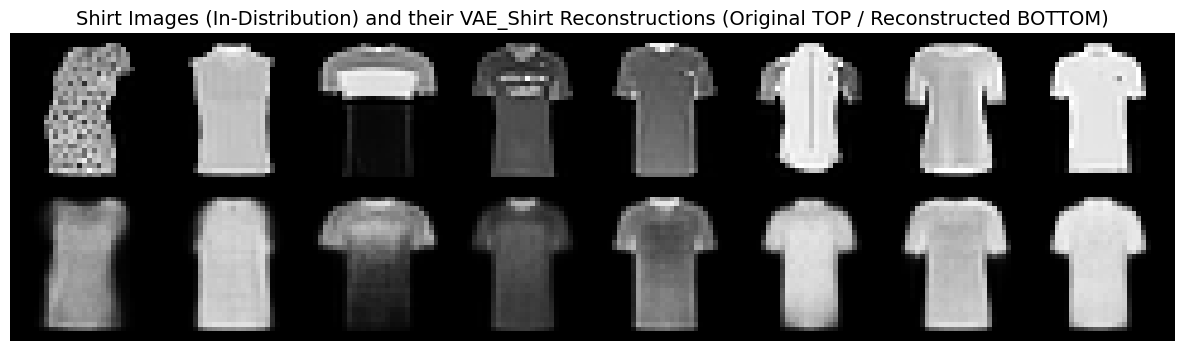

Log-Likelihood (Log P_victim) - Original:
[-290.5, -266.1, -252.2, -263.3, -298.2, -222.1, -275.3, -161.8]
Log-Likelihood (Log P_victim) - Reconstructed (E/D):
[-305.4, -256.3, -276.6, -247.0, -299.9, -220.0, -274.5, -194.9]
--> Likelihoods are expected to be around μ=-269.6
---


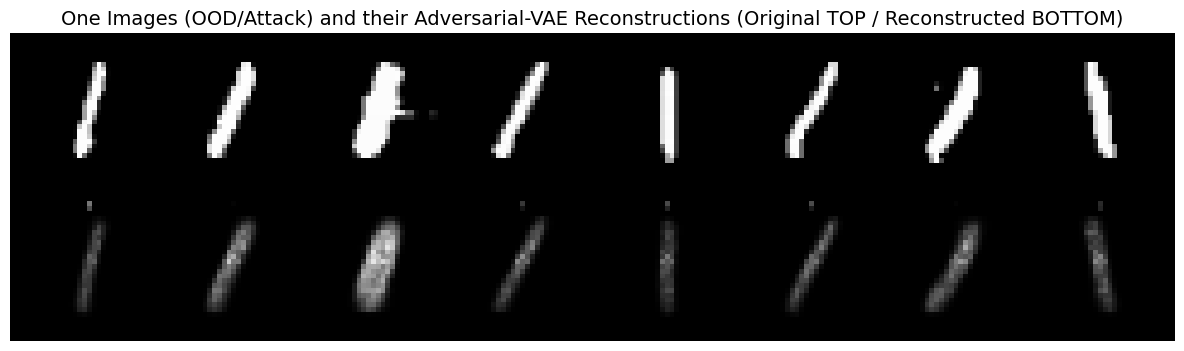

Log-Likelihood (Log P_victim) - Original:
[-139.5, -158.4, -177.5, -153.0, -140.7, -148.2, -161.3, -154.6]
Log-Likelihood (Log P_victim) - Reconstructed (E/D):
[-77.9, -102.9, -140.9, -85.6, -78.9, -83.8, -100.9, -87.0]
--> Likelihoods of the reconstructed images (bottom) should exceed the threshold -429.7
---
## 2. Computing NLL distributions for Shirts, Original Ones, and Reconstructed Ones
Shirts   NLL: mean=269.62
Orig 1s  NLL: mean=149.24
Recon 1s NLL: mean=83.69
NLL threshold (from μ - 3.0σ): 429.67


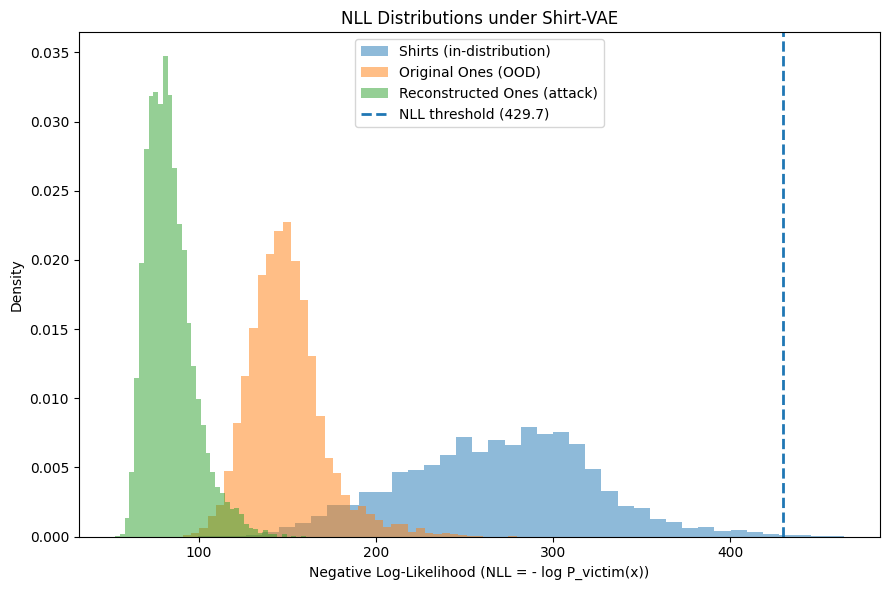

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# --- Analysis Parameters ---
# High K for a precise estimate of log-likelihood (Log P(x))
K_EVAL = 100
# Detection threshold: mean - N * std
# Examples are rejected if log P(x) < Threshold.
# A common value is 3 sigma for anomaly detection.
N_SIGMA = 3.0

# Freeze victim model and set to eval mode
victim_model.eval()

## ----------------------------------------------------
## 1. MARGINAL MEAN AND STD OF LOG-LIKELIHOOD (VICTIM)
## ----------------------------------------------------
print("## 1. Computing Marginal Log-Likelihood (Log P(x)) for Shirts (VICTIM)")

log_p_shirts_list = []
with torch.no_grad():
    for data, _ in loader_victim:
        data = data.to(DEVICE)

        # Estimate log P(x) of real shirt images (In-Distribution)
        # We use high K for accuracy
        log_p_batch = compute_log_likelihood_is(victim_model, data, k=K_EVAL)
        log_p_shirts_list.extend(log_p_batch.cpu().numpy())

log_p_shirts_array = np.array(log_p_shirts_list)
mean_log_p = np.mean(log_p_shirts_array)
std_log_p = np.std(log_p_shirts_array)

# Detection threshold
# An adversarial example MUST have log P(x) above this value
# to AVOID being detected by the marginal detector
detection_threshold = mean_log_p - (N_SIGMA * std_log_p)

print(f"--- Statistical Analysis (Shirts) ---")
print(f"Marginal Mean (μ): {mean_log_p:.2f}")
print(f"Standard Deviation (σ): {std_log_p:.2f}")
print(f"Detection Threshold (μ - {N_SIGMA}σ): {detection_threshold:.2f} \n")
print(f"--> The Log P(x) of ADVERSARIAL ONES must be GREATER than {detection_threshold:.2f} to evade detection.")

## ----------------------------------------------------
## 2. IMAGE GENERATION AND PLOTTING
## ----------------------------------------------------

def plot_reconstructions(model, dataloader, title, n_samples=8):
    """
    Generate and plot reconstructions for a batch of data.
    Top row: originals.
    Bottom row: reconstructions through the given model.
    """
    model.eval()
    data, _ = next(iter(dataloader))
    data = data[:n_samples].to(DEVICE)

    with torch.no_grad():
        # VAE reconstruction (encode/decode pass)
        recon, _, _ = model(data)

        # Compute Log P(x) of original data under the victim
        log_p_original = compute_log_likelihood_is(victim_model, data, k=K_EVAL)

        # Compute Log P(x) of reconstructed data under the victim
        log_p_recon = compute_log_likelihood_is(victim_model, recon, k=K_EVAL)

    # Convert to image grids and plot
    original_grid = make_grid(data.view(-1, 1, 28, 28).cpu(), nrow=n_samples)
    recon_grid = make_grid(recon.view(-1, 1, 28, 28).cpu(), nrow=n_samples)

    # Concatenate original (top) and reconstruction (bottom)
    combined_image = torch.cat([original_grid, recon_grid], dim=1)

    plt.figure(figsize=(16, 4))
    plt.imshow(combined_image.permute(1, 2, 0), cmap='gray')
    plt.title(f"{title} (Original TOP / Reconstructed BOTTOM)", fontsize=14)
    plt.axis('off')
    plt.show()

    # Print metrics below the plot
    print("Log-Likelihood (Log P_victim) - Original:")
    print("[" + ", ".join(f"{lp:.1f}" for lp in log_p_original.cpu().numpy()) + "]")
    print("Log-Likelihood (Log P_victim) - Reconstructed (E/D):")
    print("[" + ", ".join(f"{lp:.1f}" for lp in log_p_recon.cpu().numpy()) + "]")


# --- Plot 1: Shirts (In-Distribution) ---
plot_reconstructions(
    victim_model,
    loader_victim,
    title="Shirt Images (In-Distribution) and their VAE_Shirt Reconstructions"
)
print(f"--> Likelihoods are expected to be around μ={mean_log_p:.1f}")
print("---")

# --- Plot 2: Ones (Out-of-Distribution / Attack) ---
# Note: we pass attacker_model to reconstruct "1"s, but
# we ALWAYS evaluate likelihood under victim_model inside the function.
plot_reconstructions(
    attacker_model,
    loader_attacker,
    title="One Images (OOD/Attack) and their Adversarial-VAE Reconstructions"
)
print(f"--> Likelihoods of the reconstructed images (bottom) should exceed the threshold {detection_threshold:.1f}")
print("---")

## ----------------------------------------------------
## 3. HISTOGRAM OF NLL:
##    - Shirts (in-distribution)
##    - Original ones (OOD)
##    - Reconstructed ones (attack)
## ----------------------------------------------------

print("## 2. Computing NLL distributions for Shirts, Original Ones, and Reconstructed Ones")

log_p_ones_list = []
log_p_recon_ones_list = []

with torch.no_grad():
    for data, _ in loader_attacker:
        data = data.to(DEVICE)

        # Log-likelihood of original ones under the shirt VAE
        log_p_ones_batch = compute_log_likelihood_is(victim_model, data, k=K_EVAL)
        log_p_ones_list.extend(log_p_ones_batch.cpu().numpy())

        # Reconstructions from attacker
        recon, _, _ = attacker_model(data)

        # Log-likelihood of reconstructed ones under the shirt VAE
        log_p_recon_batch = compute_log_likelihood_is(victim_model, recon, k=K_EVAL)
        log_p_recon_ones_list.extend(log_p_recon_batch.cpu().numpy())

log_p_ones_array = np.array(log_p_ones_list)
log_p_recon_ones_array = np.array(log_p_recon_ones_list)

# Convert to NLL = - log P(x)
nll_shirts = -log_p_shirts_array
nll_ones_orig = -log_p_ones_array
nll_ones_recon = -log_p_recon_ones_array

# NLL threshold corresponding to log-likelihood threshold
threshold_nll = -detection_threshold

print(f"Shirts   NLL: mean={nll_shirts.mean():.2f}")
print(f"Orig 1s  NLL: mean={nll_ones_orig.mean():.2f}")
print(f"Recon 1s NLL: mean={nll_ones_recon.mean():.2f}")
print(f"NLL threshold (from μ - {N_SIGMA}σ): {threshold_nll:.2f}")

# Build a common range for histograms
all_nll = np.concatenate([nll_shirts, nll_ones_orig, nll_ones_recon])
bins = 40

plt.figure(figsize=(9, 6))
plt.hist(nll_shirts, bins=bins, density=True, alpha=0.5, label="Shirts (in-distribution)")
plt.hist(nll_ones_orig, bins=bins, density=True, alpha=0.5, label="Original Ones (OOD)")
plt.hist(nll_ones_recon, bins=bins, density=True, alpha=0.5, label="Reconstructed Ones (attack)")

plt.axvline(threshold_nll, linestyle="--", linewidth=2,
            label=f"NLL threshold ({threshold_nll:.1f})")

plt.xlabel("Negative Log-Likelihood (NLL = - log P_victim(x))")
plt.ylabel("Density")
plt.title("NLL Distributions under Shirt-VAE")
plt.legend()
plt.tight_layout()
plt.show()
